# Cirrus Clouds in a Warming World

### Background

<div class="container">
     
<img align="right" width="450" height="90" src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/Cloud_types_en.svg/2560px-Cloud_types_en.svg.png" alt="Cloud Guide for Coton, Wikipedia Commons" style="opacity:0.8;filter:alpha(opacity=80);" />

Cirrus clouds are high, wispy clouds that are believed to have a net warming effect. Much about cirrus clouds and their impact on the climate system is still not certain:

   - will they increase?
   - will their spatial/temporal distributions change?
   
Challenges in understanding cirrus clouds:
   - clouds are difficult to model!
   - varied crystal structures
   - ice crystals orientations
   - challenging to observe
    
MODIS satellite uses 1.375 	&mu;m narrow band to detect cirrus reflectance. Data is available from 7/2002 to 9/2020.
<div style="text-align: right"> <i>from Coton Cloud Guide, accessed via Wikipedia Commons<i> </div>   

   <font face = "Garamond" size = "4" ><center><b>Reflectance<sub>1.375</sub> = Reflected<sub>1.375</sub> / Incident<sub>1.375</sub><b> <center></font> 
  
</div>   
       
**Question**: Has there been significant change in the total global cirrus reflectance, seasonal or latitudinal distribution of cirrus clouds?

       
    


### Setting Up the Notebook & Organizing the Data

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as sp
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

import cartopy.crs as ccrs
import cartopy

In [2]:
!pip install fsspec==0.8.4

In [3]:
!pip install 'git+git://github.com/tjcrone/gdrivefs.git@540a55fae06cbed4f7d9f8d540ac29fcb640c38a'
;

  Cloning git://github.com/tjcrone/gdrivefs.git (to revision 540a55fae06cbed4f7d9f8d540ac29fcb640c38a) to /tmp/pip-req-build-fzwcjqh0
  Created wheel for gdrivefs: filename=gdrivefs-0+untagged.18.g540a55f-py3-none-any.whl size=7302 sha256=2d01754a49cb7e340cf612edd36c2d0f4f60ec447cc8250b1eb20aa862cab010
  Stored in directory: /home/jovyan/.cache/pip/wheels/15/4c/f1/4e7c595331abdbc521e37b85bfe0bac4d9ade7a651260cb97f
Successfully built gdrivefs


''

In [4]:
!pip install paramiko

In [5]:
import gdrivefs
#gdrivefs.__version__

In [9]:
gdfid = '1kF5NUKTGXzoUXrAoB2NLkB5vStzT0F6X'
gdfs = gdrivefs.GoogleDriveFileSystem(root_file_id=gdfid, token='browser')

In [10]:
files = gdfs.ls('/')
f = gdfs.open(files[0])

In [11]:
cirrus = xr.open_dataset(f)
cirrus

<xarray.Dataset>
Dimensions:      (lat: 180, lon: 360, time: 219)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time         (time) float64 7.314e+05 7.314e+05 ... 7.38e+05 7.38e+05
Data variables:
    Reflectance  (time, lon, lat) float64 ...

In [12]:
#f.close()

Note that the time is given by an integer; I'll need to convert to a datetime object.

First, though, I had to fix an issue with the integers values, since they are a year and a day off from what they should be. 

In [13]:
test1 = datetime.fromordinal(cirrus.time[0])
print(test1)
test2 = datetime.fromordinal(cirrus.time[218])
print(test2)

2003-07-02 00:00:00
2021-09-02 00:00:00


In [14]:
discrepancy = 366
date = []
timenum = cirrus['time'] - discrepancy

for i in cirrus.time:
    date.append(datetime.fromordinal(i-discrepancy))
    
cirrus['time'] = date

I must have made a mistake when writing the netcdf file. I'll also need to rotate my data and flip the coordinate values on my latitude axis. 

In [15]:
cirrus = cirrus.transpose('lat', 'lon', 'time')
latflip = (cirrus.lat)*-1
cirrus['lat'] = latflip

### Finding the Average Monthly Cirrus Reflectance

Before I look at how things are changing, I first need to understand what the typical patterns are. To get a qualitative understanding of cirrus distributions, I found the mean monthly reflectance and standard deviation for each gridpoint.

In [16]:
mm = cirrus.groupby('time.month').mean(dim='time',skipna=False)
#ms = cirrus.groupby('time.month').std(dim='time', skipna=False) #removed for run-time considerations

''

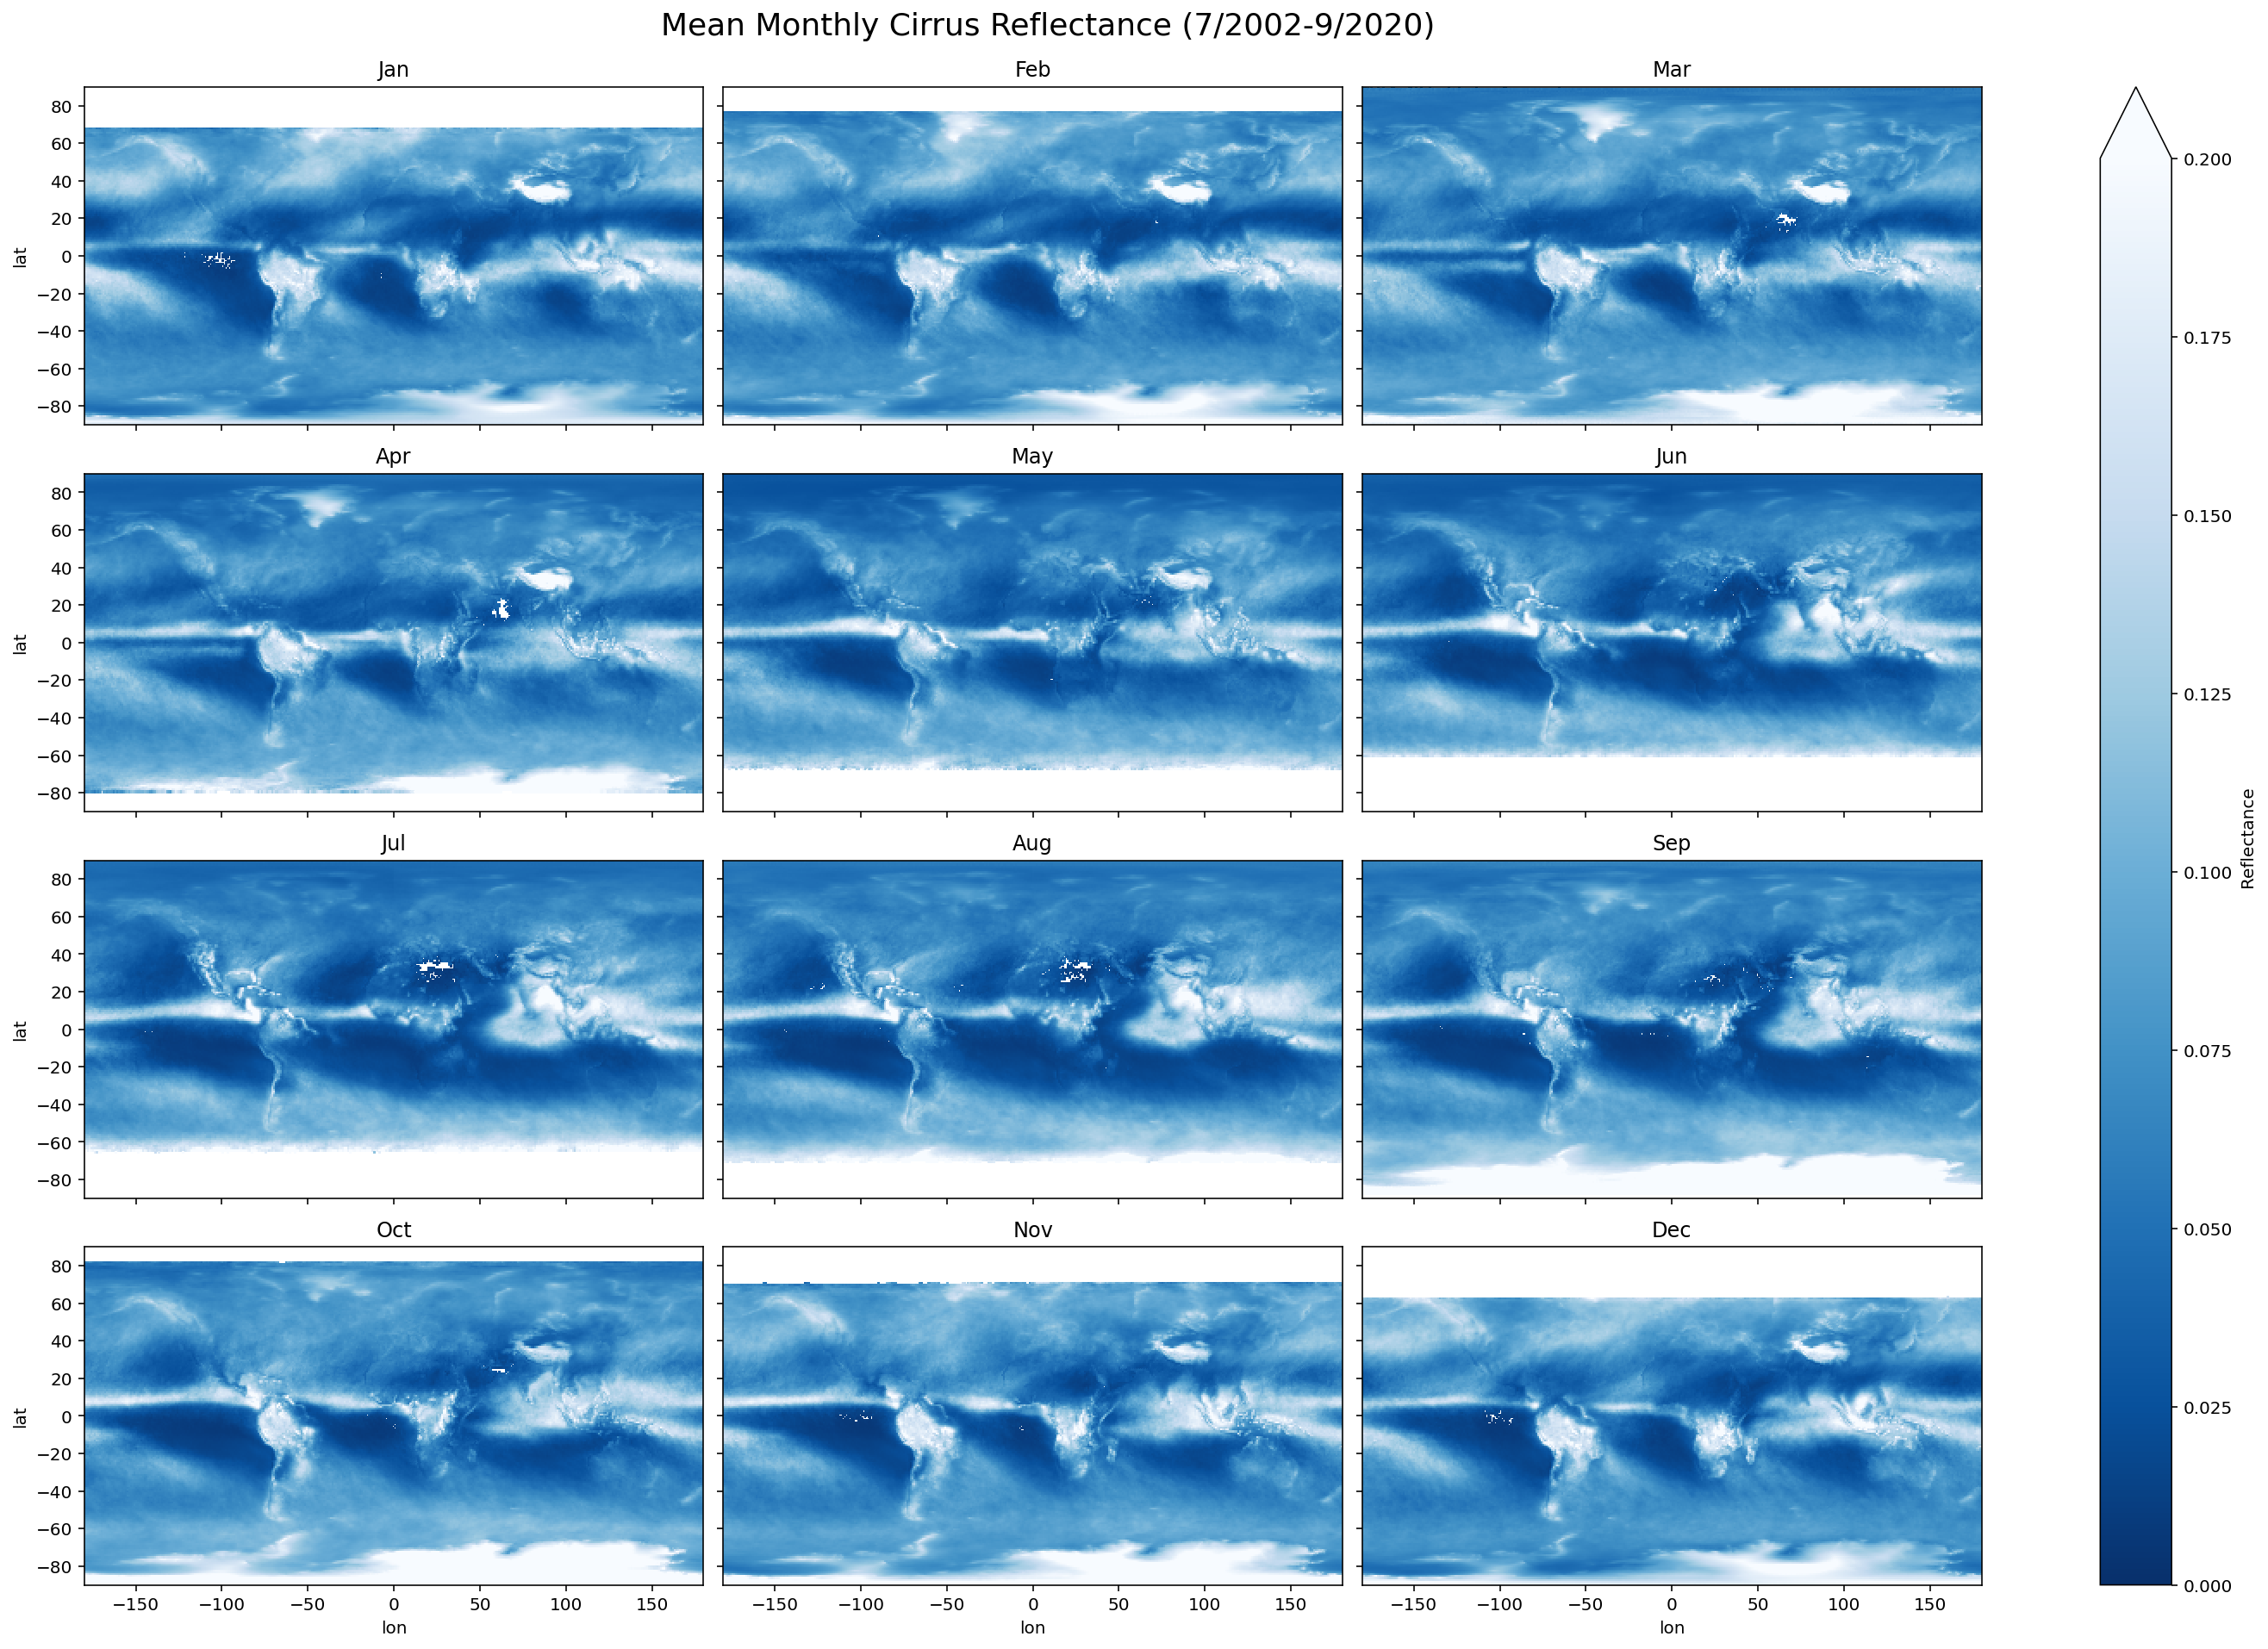

In [17]:
monthnames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

mp = mm.Reflectance.plot(x='lon',y='lat',
                    col='month',
                    col_wrap=3, 
                    cmap='Blues_r',
                    figsize = (20,13), 
                    vmin=0, 
                    vmax=.2,
                    )                    

for i, ax in enumerate(mp.axes.flat):
    ax.set_title(monthnames[i])
    
mp.fig.suptitle('Mean Monthly Cirrus Reflectance (7/2002-9/2020)', y=1.02, x=.425, fontsize=18)
;

Now I'll look at the average global seasonal cycle, but first I'll need to weight the areas. 

In [18]:
wvec = np.cos(np.deg2rad(cirrus.lat)) / np.cos(np.deg2rad(cirrus.lat)).mean()
weight , lon = xr.broadcast(wvec, cirrus.lon)
mm_aw = np.multiply(weight, mm)
cirrus_aw = np.multiply(weight, cirrus)

For comparison, I'll consider zonal averages as well. 

In [19]:
binlabels = ['Polar_nh','Midlats_nh','Tropics_nh','Tropics_sh','Midlats_sh','Polar_sh']
zonal = cirrus_aw.groupby_bins(cirrus_aw.lat, 6, labels=binlabels).mean()

I'll want to consider the standard error as well. Now I'll plot the global and zonal annual cycles, as well as the error for each month in the global series. 

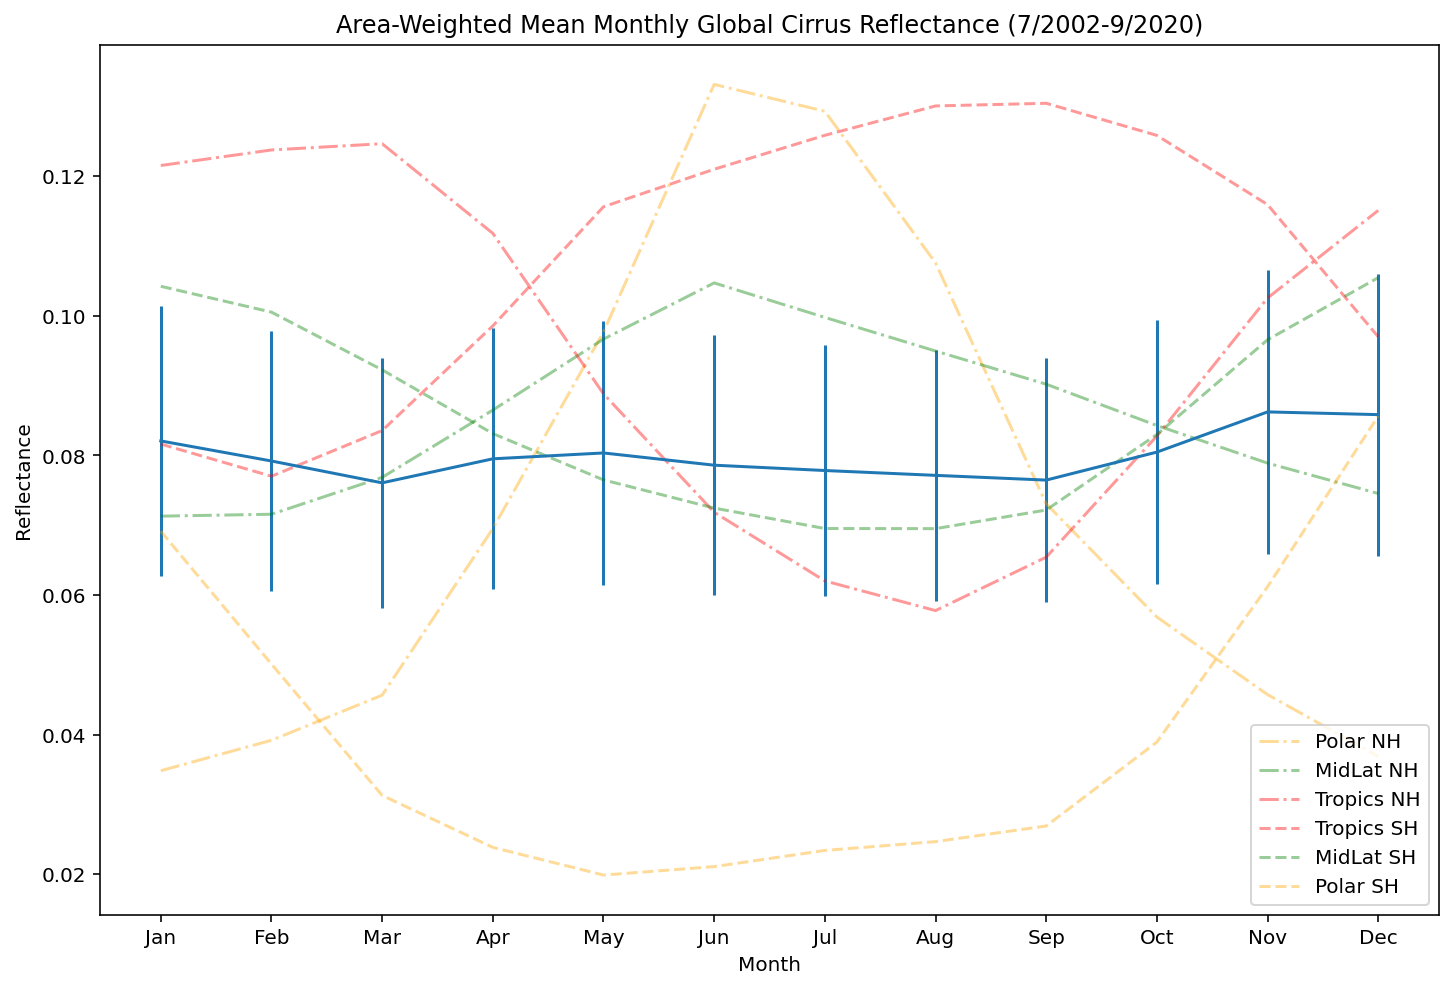

''

In [20]:
annual = mm_aw.mean(dim=['lon','lat'])
SE = cirrus_aw.mean(dim=['lon','lat']).groupby('time.month').mean(dim='time')/np.sqrt(cirrus_aw.mean(dim=['lon','lat']).groupby('time.month').count())

fig, ax = plt.subplots()

ax.errorbar(annual.month, 
            annual.Reflectance, 
            yerr=SE.Reflectance)

latbands = ['Polar NH', 'MidLat NH', 'Tropics NH', 'Tropics SH', 'MidLat SH', 'Polar SH']
colorchoice = ['orange','green','red','red','green','orange']
linechoice = ['-.','-.','-.','--','--','--']

i=0;
for group in zonal.Reflectance:
    label = latbands[i]
    lc = linechoice[i]
    cc = colorchoice[i]
    i=i+1
    group.mean(dim='lon').groupby('time.month').mean(dim='time').plot.line(alpha=.4, 
                                                                           linestyle=lc,
                                                                           color=cc,
                                                                           ax=ax,
                                                                           label=label
                                                                          )
handles, labels = ax.get_legend_handles_labels()
ax.legend(latbands);
ax.set_ylabel('Reflectance')
ax.set_xlabel('Month')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(monthnames)
ax.set_title('Area-Weighted Mean Monthly Global Cirrus Reflectance (7/2002-9/2020)')


plt.show()

;

Notice that the errorbars on the global mean monthly reflectance overshaddow the seasonality. As you would expect, corresponding zones in the respective hemispheres show broadly opposite seasonal cycles. However it is notable that the midlatitudes and tropics in the same hemispheres also show opposing seasonal cycles. Note that because satellite data measures reflected solar radiation, the polar zones will have limited data in the winter.

### Is Global Cirrus Reflectance Increasing with Time?

Now I'll consider the timeseries. As might be expected, the noisiness of the data makes it difficult to perceive any obvious trend. By resampling the monthly anomalies at 1 year I can remove the seasonal cycle and (perhaps) more easily perceive larger trends. I will consider standardized anomalies.

''

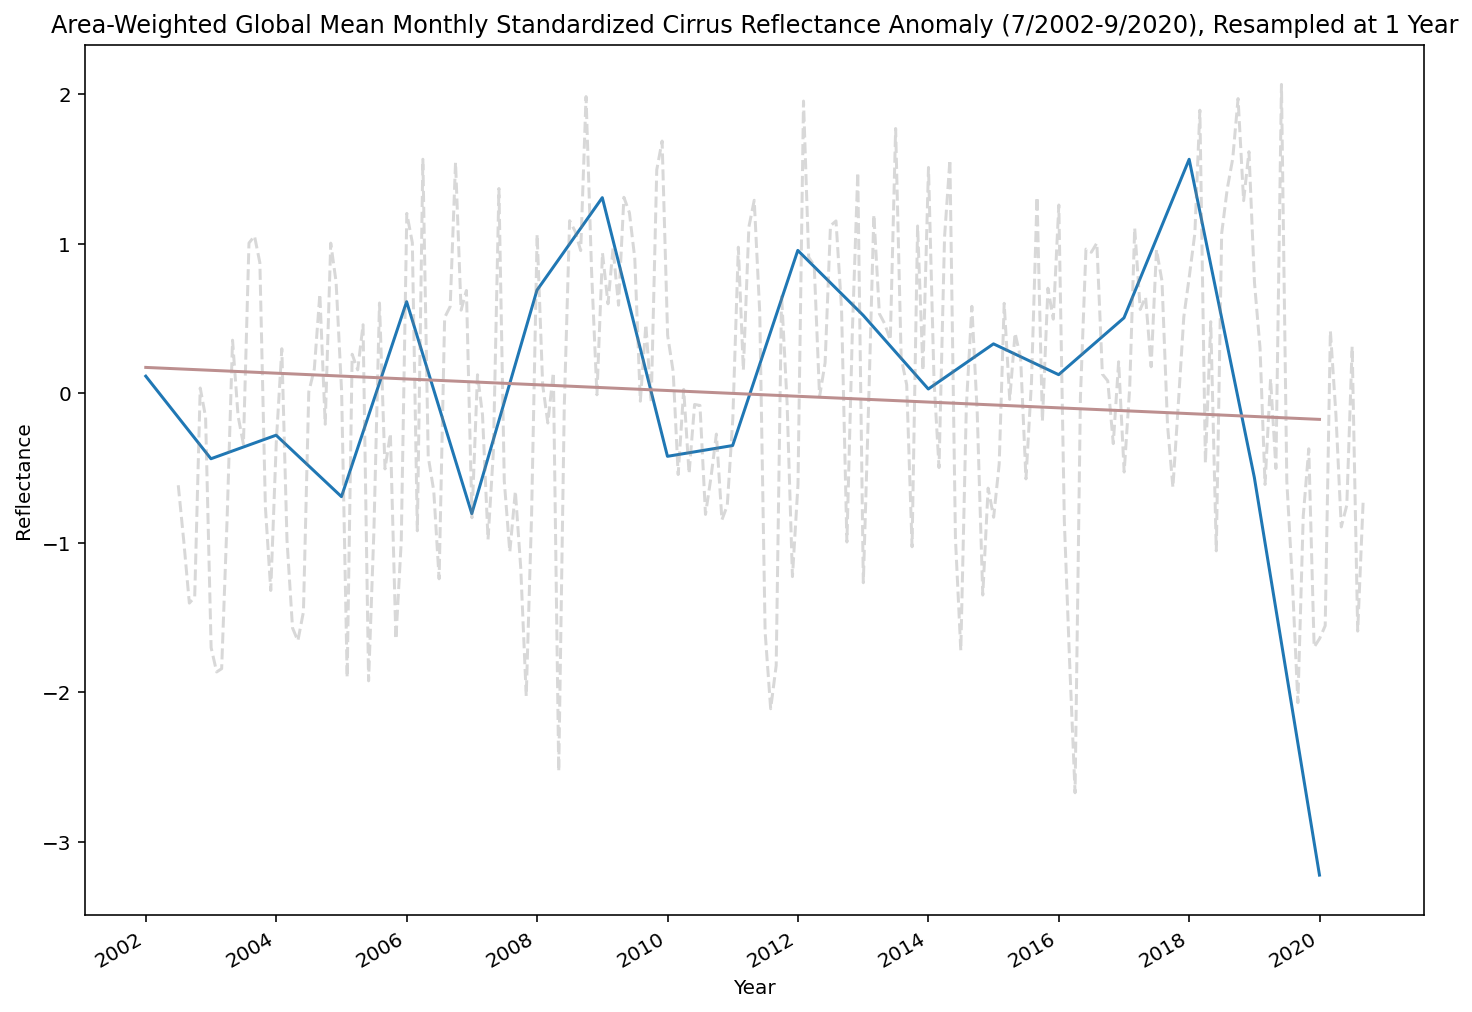

In [21]:
fig, ax = plt.subplots()

am_aw = cirrus_aw.mean(dim=['lat','lon']).resample(time='Y', loffset='-1Y').mean()
am_anom_gl = am_aw - am_aw.mean()
am_stanom_gl = am_anom_gl/am_anom_gl.std(dim='time')
am_stanom_gl.Reflectance.plot(ax=ax)

mm_anom_gl = cirrus_aw.mean(dim=['lat','lon']).groupby('time.month') - cirrus_aw.mean(dim=['lat','lon']).groupby('time.month').mean(dim='time')
mm_stanom_gl = mm_anom_gl.groupby('time.month')/cirrus_aw.mean(dim=['lat','lon']).groupby('time.month').std(dim='time')
mm_stanom_gl.Reflectance.plot(alpha=.3, color='gray', linestyle='--', ax=ax)


y=np.array(am_stanom_gl['Reflectance'].dropna(dim='time').values, dtype=float)
x=np.array(am_stanom_gl['time'].dropna(dim='time').values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),19)
xf1 = xf.copy()
yf = (slope*xf)+intercept

ax.plot(am_stanom_gl.time,yf, color='rosybrown')

ax.set_xlabel('Year')
ax.set_title('Area-Weighted Global Mean Monthly Standardized Cirrus Reflectance Anomaly (7/2002-9/2020), Resampled at 1 Year')
;

While the overall trend is not significant, the 2020 anomaly is strinking at 3 standard deviations below the mean. I'm curious whether the reduction in air travel this year, or perhaps global reductions in aerosols (which can act as CCNs), may have contributed to this. However, it's also notable that I only have data for the first 9 months of 2020. I'll be able to test the significance of this reduction more definitively once I have data from the rest of the year. 

I'll also consider the timeseries of the different zones identified above. 

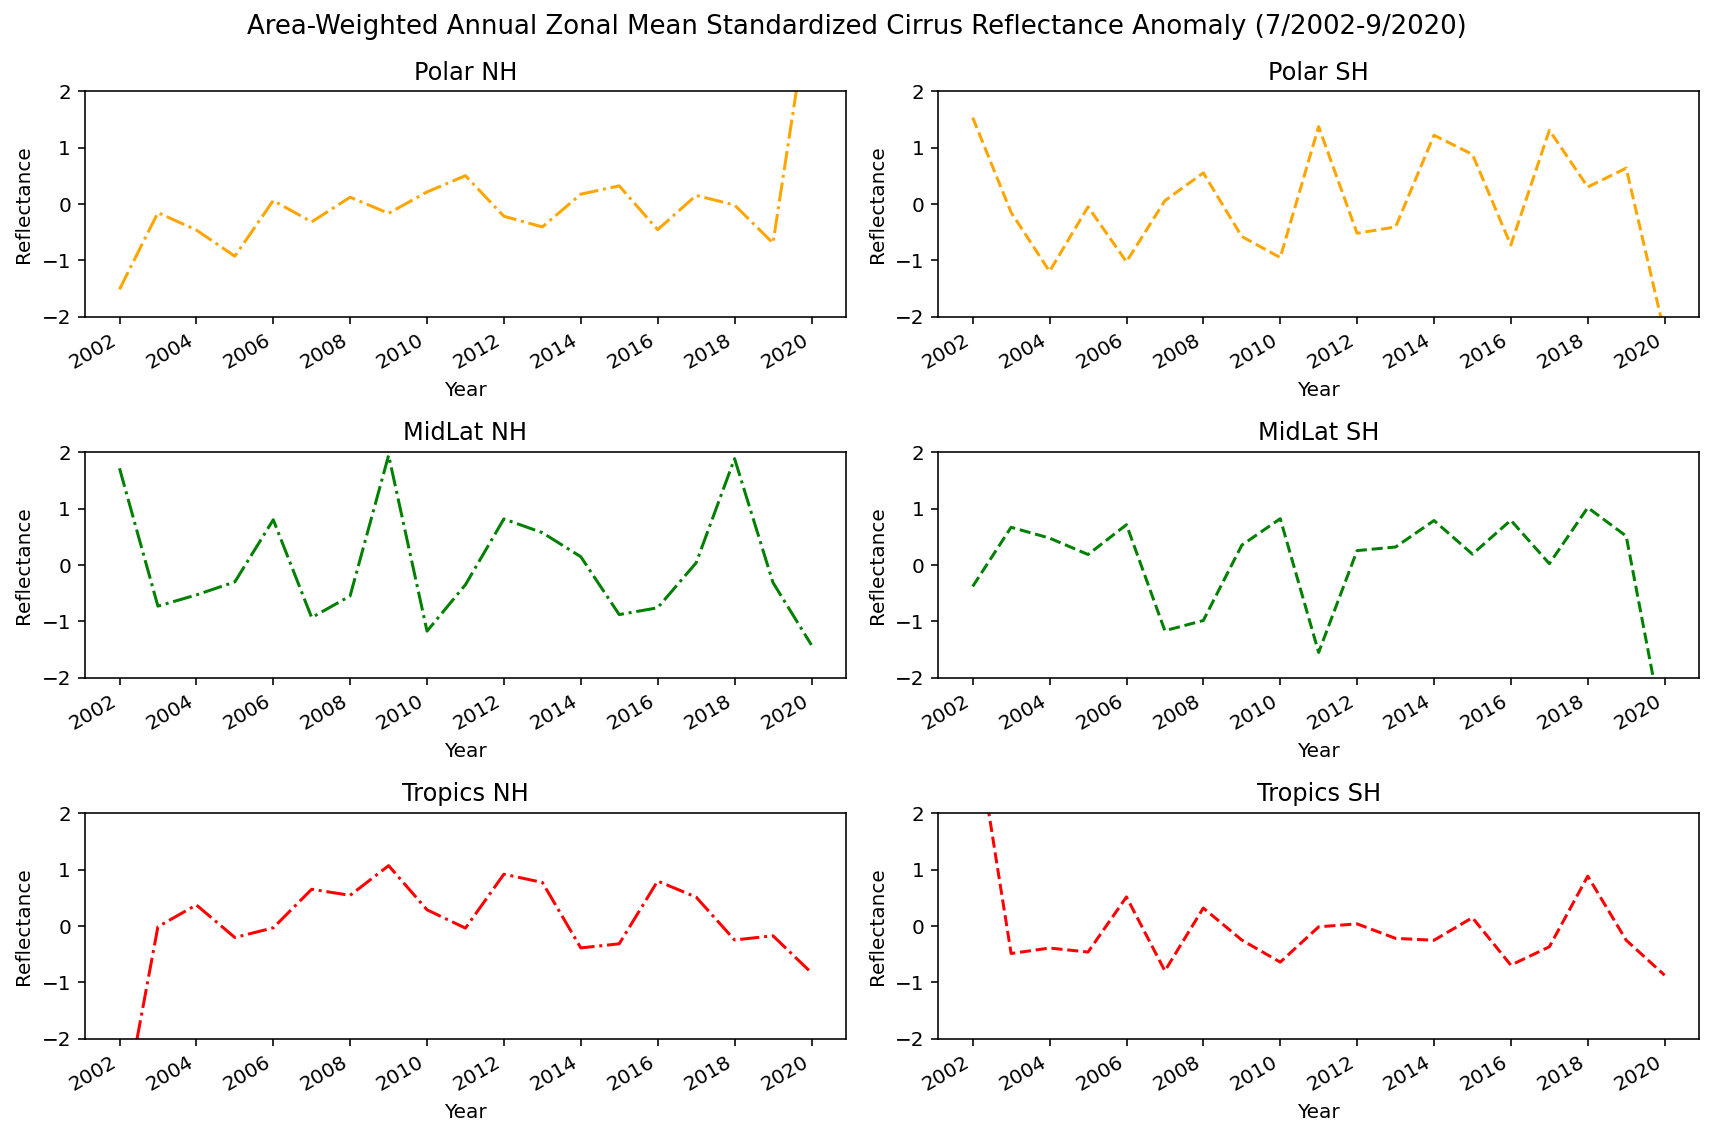

''

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=2, tight_layout=True)

i=0;
for group in zonal.Reflectance:
    label = latbands[i]
    lc = linechoice[i]
    cc = colorchoice[i]
    
    r = np.absolute(2-np.floor(np.absolute(i-2.5))).astype(int)
    c = np.floor(i/3).astype(int)
    
    g_res = group.mean(dim='lon').resample(time='Y', loffset='-1Y').mean()
    g_anom = g_res - g_res.mean()
    g_stanom = g_anom/g_anom.std(dim='time')
    g_stanom.plot(linestyle=lc,
                  color=cc, 
                  ax=ax[r,c], 
                )
    ax[r,c].set_ylim((-2, 2)) 
    ax[r,c].title.set_text(latbands[i])
    ax[r,c].set_xlabel('Year')
    i=i+1

fig.suptitle('Area-Weighted Annual Zonal Mean Standardized Cirrus Reflectance Anomaly (7/2002-9/2020)', fontsize=13)
plt.show()
;

### Mapping 2020 Anomalies

Because 2020 anomaly was so anomalous, I want to look at this year more closely. I'll plot the average global mean monthly anomalies for the first 9 months.

In [ ]:
anom = (cirrus.groupby('time.month') - cirrus.groupby('time.month').mean(dim='time', skipna=False))
stdev = anom.groupby('time.month').std(dim='time')
stanom = anom.groupby('time.month')/stdev
stanom2020 = stanom.sel(time=slice("2020-01-01", "2020-09-01")).mean(dim='time')

fig = plt.figure(figsize = (18,10))
ax = plt.axes(projection = ccrs.Mollweide())

ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.gridlines()
stanom2020.Reflectance.plot(ax=ax,
                           transform=ccrs.PlateCarree(),
                           cmap='RdBu_r',  
                        )

ax.set_title('Standardized Cirrus Reflectance Anomalies (Jan-Sep 2020)', y=1.05, x=.525, fontsize=14)
;

### Just for Fun

How do zonal mean cirrus clouds change with time? Here I visualize the timeseries of mean zonal reflectance using a Hovmoller-inspired diagram, with the goal of qualitatively assessing any trends in the distribution of cirrus reflectance that could involve both latitudinal and temporal shifts. However, the resulting figure is remarkably regular and it appears that any global trends in cirrus distribution are slight at best. 

In [ ]:
fig, ax = plt.subplots(figsize = (18,10))

zonal = cirrus.mean(dim='lon')
zonal.Reflectance.plot(cmap='Blues_r', 
                       vmax=.15, 
                       vmin=.0, 
                       ax=ax,
                       )

ax.set_title('Mean Zonal Cirrus Reflectance from Jan 2002 to Sept 2020', fontsize=14, y=1.02)
ax.set_xlabel('Year')
ax.set_ylabel('Latitude')
;